In [28]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

import numpy as np

def load_plateau01_rms_per_channel(path, cut_index = "idx01", use_all=False):
    """
    path: path to *_combined.npy
    Returns: RMS per channel (length 16) computed on plateau 01
             (or on indices_all if use_all=True).
    """
    pp = np.load(path, allow_pickle=True).item()

    emg = pp["EMG"]  # shape (16, N_time)

    # find the plateau cut dict
    plateau_cuts = [c for c in pp["cuts"] if c.get("kind") == "plateau"]
    if not plateau_cuts:
        raise ValueError(f"No plateau cut found in {path}")
    cut = plateau_cuts[0]

    # choose which indices to use
    if use_all:
        idx = cut["indices_all"]   # union of plateau segments
    else:
        idx = cut[cut_index]         # plateau 01 only

    # select plateau samples
    emg_plateau = emg[:, idx]      # still (16, T_plateau)

    # RMS per channel over time axis (axis=1, since channels are axis=0)
    rms_per_channel = np.sqrt(np.mean(emg_plateau**2, axis=1))
    return rms_per_channel


RMS shapes: (16,) (16,) (16,)


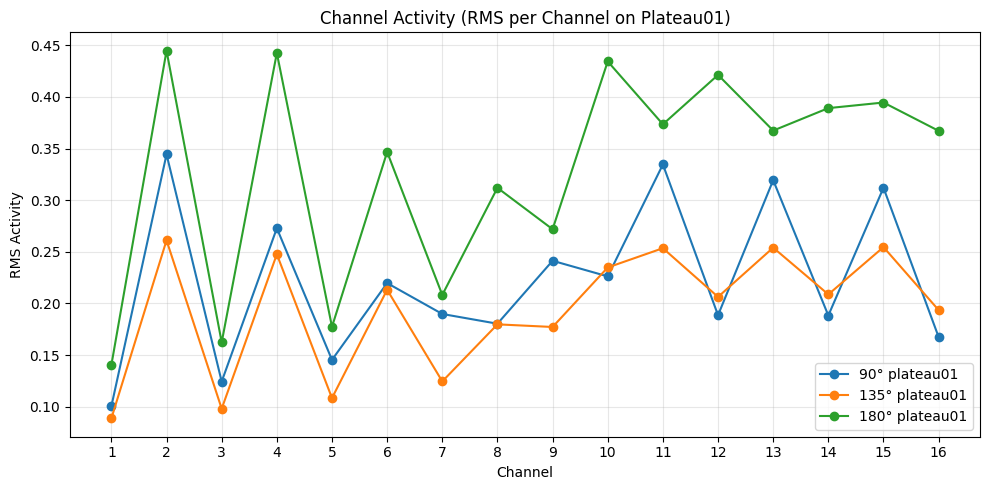

In [29]:
import matplotlib.pyplot as plt
import numpy as np

FILE_90  = "data/preprocessing/P3_combined/90Deg_F1_1_combined.npy"
FILE_135 = "data/preprocessing/P3_combined/135Deg_F1_1_combined.npy"
FILE_180 = "data/preprocessing/P3_combined/180Deg_F2_1_combined.npy"

rms_90  = load_plateau01_rms_per_channel(FILE_90)
rms_135 = load_plateau01_rms_per_channel(FILE_135)
rms_180 = load_plateau01_rms_per_channel(FILE_180)

print("RMS shapes:", rms_90.shape, rms_135.shape, rms_180.shape)  # should all be (16,)

channels = np.arange(1, 17)

plt.figure(figsize=(10, 5))

plt.plot(channels, rms_90,  marker='o', label="90° plateau01")
plt.plot(channels, rms_135, marker='o', label="135° plateau01")
plt.plot(channels, rms_180, marker='o', label="180° plateau01")

plt.title("Channel Activity (RMS per Channel on Plateau01)")
plt.xlabel("Channel")
plt.ylabel("RMS Activity")
plt.xticks(channels)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


RMS shapes: (16,) (16,) (16,)


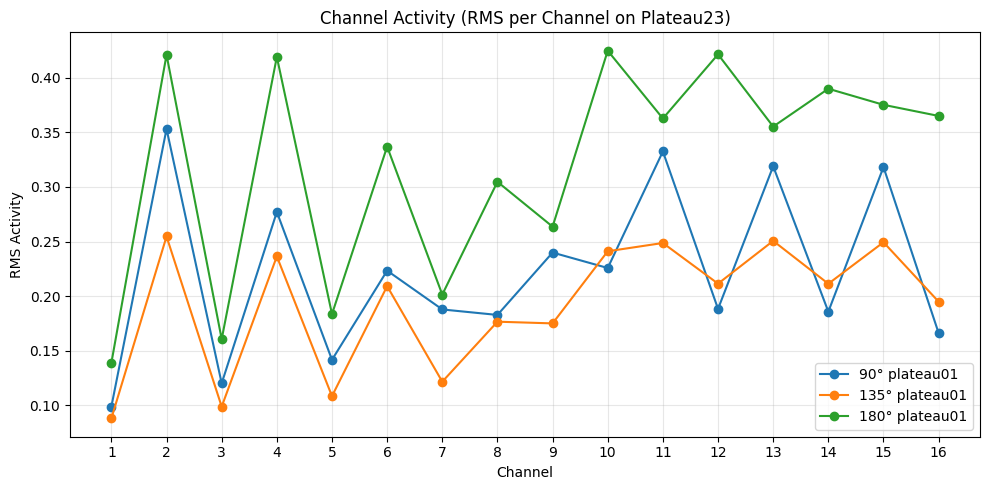

In [32]:
rms_90  = load_plateau01_rms_per_channel(FILE_90, cut_index="idx23")
rms_135 = load_plateau01_rms_per_channel(FILE_135, cut_index="idx23")
rms_180 = load_plateau01_rms_per_channel(FILE_180, cut_index="idx23")

print("RMS shapes:", rms_90.shape, rms_135.shape, rms_180.shape)  # should all be (16,)

channels = np.arange(1, 17)

plt.figure(figsize=(10, 5))

plt.plot(channels, rms_90,  marker='o', label="90° plateau01")
plt.plot(channels, rms_135, marker='o', label="135° plateau01")
plt.plot(channels, rms_180, marker='o', label="180° plateau01")

plt.title("Channel Activity (RMS per Channel on Plateau23)")
plt.xlabel("Channel")
plt.ylabel("RMS Activity")
plt.xticks(channels)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple
from data.preprocessing.preprocess import preprocess_plateaus 
# -------------------------------
# Helpers: get segments + RMS windows
# -------------------------------

def get_segments_for_file(
    path: str,
    rms_win_samples: int = 100,
    segment_kind: str = "plateau",
) -> List[Dict[str, Any]]:
    """
    Load a *_combined.npy payload and run preprocess_plateaus on it.
    Returns the list of segments (plateau01, plateau23, ...).
    """
    payload = np.load(path, allow_pickle=True).item()

    pp_proc = preprocess_plateaus(
        payload=payload,
        rms_win_samples=rms_win_samples,
        modes=("rms_matrix",),        # we only need per-channel RMS
        keep_intended_angle=True,
        segment_kind=segment_kind,
    )

    return pp_proc["segments"]

def get_rms_windows_from_segments(
    segments: List[Dict[str, Any]],
    plateau: str = "01",
) -> Tuple[np.ndarray, np.ndarray]:
    """
    From the preprocessed segments list, extract the rms_matrix and time vector
    for a given plateau ("01" or "23").

    Returns:
        R: (N_windows, C_channels)  RMS per window per channel
        t: (N_windows,)             time stamps for the RMS samples
    """
    suffix = str(plateau)
    for seg in segments:
        if seg["name"].endswith(suffix):
            R = seg["emg"]["rms_matrix"]   # (N, C)
            t = seg["signals"]["t"]        # (N,)
            return R, t

    raise ValueError(f"No segment with name ending in '{suffix}' found. "
                     f"Available: {[s['name'] for s in segments]}")

# -------------------------------
# Main plotting function
# -------------------------------

def plot_window_consistency_for_file(
    path: str,
    plateau: str = "01",
    rms_win_samples: int = 100,
    alpha: float = 0.15,
):
    """
    For a single file:
      - preprocess plateaus
      - take chosen plateau ('01' or '23')
      - plot RMS activity across channels for *each* window

    This gives many lines (one per window) so you can visually assess
    how constant the channel activity profile is within that contraction.
    """
    segments = get_segments_for_file(
        path=path,
        rms_win_samples=rms_win_samples,
        segment_kind="plateau",
    )

    R, t = get_rms_windows_from_segments(segments, plateau=plateau)  # R: (N, C)
    N, C = R.shape
    channels = np.arange(1, C + 1)

    plt.figure(figsize=(10, 5))

    # Plot one line per window
    for i in range(N):
        plt.plot(channels, R[i], alpha=alpha)

    plt.title(f"Window-wise channel activity\n{path.split('/')[-1]} — plateau{plateau}")
    plt.xlabel("Channel")
    plt.ylabel("RMS activity")
    plt.xticks(channels)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Example usage (assuming FILE_135 etc. defined above)
# -------------------------------
# plot_window_consistency_for_file(FILE_135, plateau="01", rms_win_samples=100)
# plot_window_consistency_for_file(FILE_135, plateau="23", rms_win_samples=100)


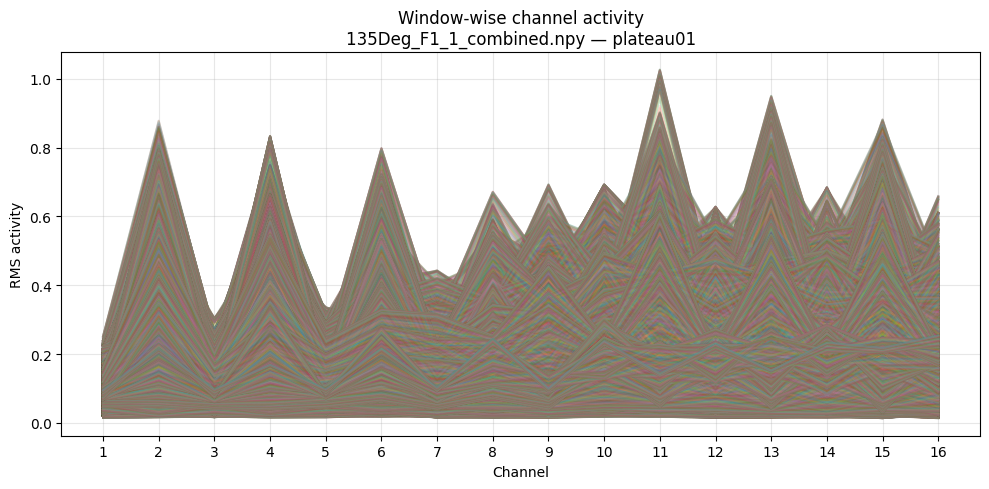

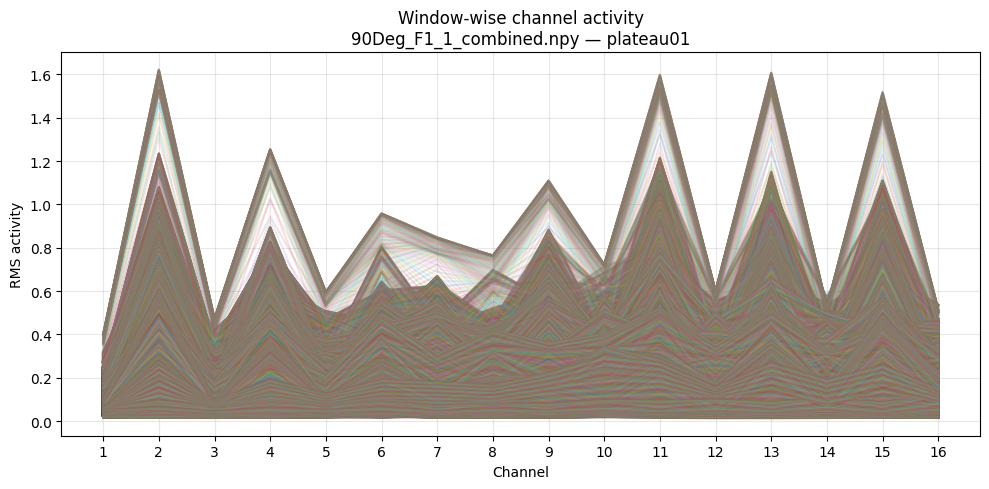

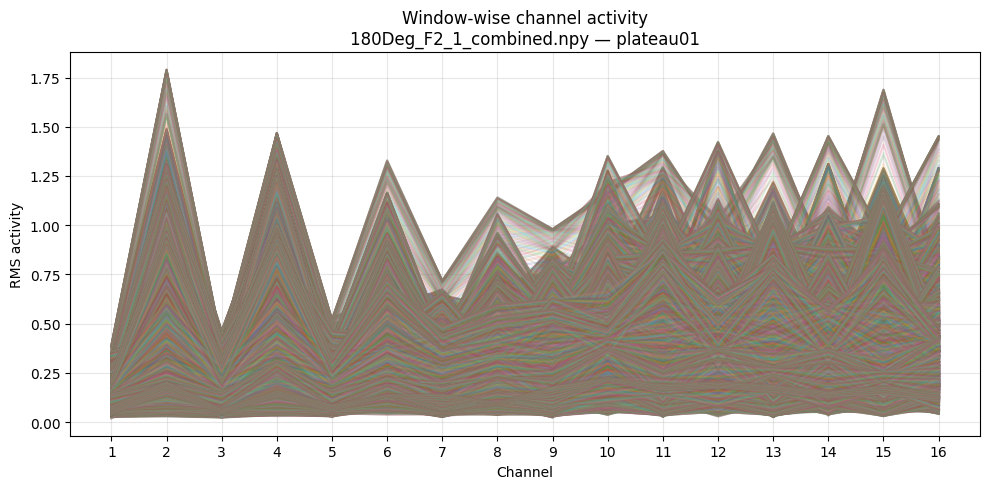

In [37]:
plot_window_consistency_for_file(FILE_135, plateau="01")
plot_window_consistency_for_file(FILE_90, plateau="01")
plot_window_consistency_for_file(FILE_180, plateau="01")

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple

# ------------------------------------------------------------------
# Helpers: get segments + RMS windows (reuses preprocess_plateaus)
# ------------------------------------------------------------------

def get_segments_for_file(
    path: str,
    rms_win_samples: int = 100,
    segment_kind: str = "plateau",
) -> List[Dict[str, Any]]:
    payload = np.load(path, allow_pickle=True).item()

    pp_proc = preprocess_plateaus(
        payload=payload,
        rms_win_samples=rms_win_samples,
        modes=("rms_matrix",),
        keep_intended_angle=True,
        segment_kind=segment_kind,
    )
    return pp_proc["segments"]


def get_rms_windows_from_segments(
    segments: List[Dict[str, Any]],
    plateau: str = "01",
) -> Tuple[np.ndarray, np.ndarray]:
    suffix = str(plateau)
    for seg in segments:
        if seg["name"].endswith(suffix):
            R = seg["emg"]["rms_matrix"]
            t = seg["signals"]["t"]
            return R, t

    raise ValueError(f"No plateau {plateau} found. Available: {[s['name'] for s in segments]}")


# ------------------------------------------------------------------
# Farthest Point Sampling (FPS) for diversity selection
# ------------------------------------------------------------------

def farthest_point_sampling(X: np.ndarray, k: int) -> List[int]:
    """
    X: (N, C) RMS windows
    k: number of diverse samples to pick
    Returns: list of selected indices
    """
    N = X.shape[0]
    k = min(k, N)

    # Start with window that has largest norm (arbitrary but stable)
    d0 = np.linalg.norm(X, axis=1)
    first = int(np.argmax(d0))
    selected = [first]

    # Distance array: min dist to any selected point
    dist = np.linalg.norm(X - X[first], axis=1)

    for _ in range(1, k):
        idx = int(np.argmax(dist))
        selected.append(idx)
        new_dist = np.linalg.norm(X - X[idx], axis=1)
        dist = np.minimum(dist, new_dist)

    return selected


# ------------------------------------------------------------------
# Main: Plot 10 most different windows
# ------------------------------------------------------------------

def plot_10_most_different_windows(
    path: str,
    plateau: str = "01",
    rms_win_samples: int = 5000,
    k: int = 10,
):
    # Load RMS windows
    segments = get_segments_for_file(path, rms_win_samples)
    R, t = get_rms_windows_from_segments(segments, plateau)
    N, C = R.shape
    channels = np.arange(1, C + 1)

    # Select k most different windows via FPS
    selected = farthest_point_sampling(R, k)
    selected_sorted = sorted(selected)   # sort by time

    plt.figure(figsize=(10, 6))

    for idx in selected_sorted:
        # position within segment
        perc = (idx / (N - 1)) * 100 if N > 1 else 0.0
        label = f"idx={idx}, t={t[idx]:.2f}s ({perc:.1f}%)"
        plt.plot(channels, R[idx], marker='o', label=label)

    plt.title(f"Most Different RMS Windows ({k}) — {path.split('/')[-1]} — plateau {plateau}")
    plt.xlabel("Channel")
    plt.ylabel("RMS Activity")
    plt.xticks(channels)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Text summary
    print("\nMost different windows:")
    for idx in selected_sorted:
        perc = (idx / (N - 1)) * 100 if N > 1 else 0.0
        print(f"  idx={idx:4d}, t={t[idx]:.3f}s, at {perc:5.1f}% of segment")


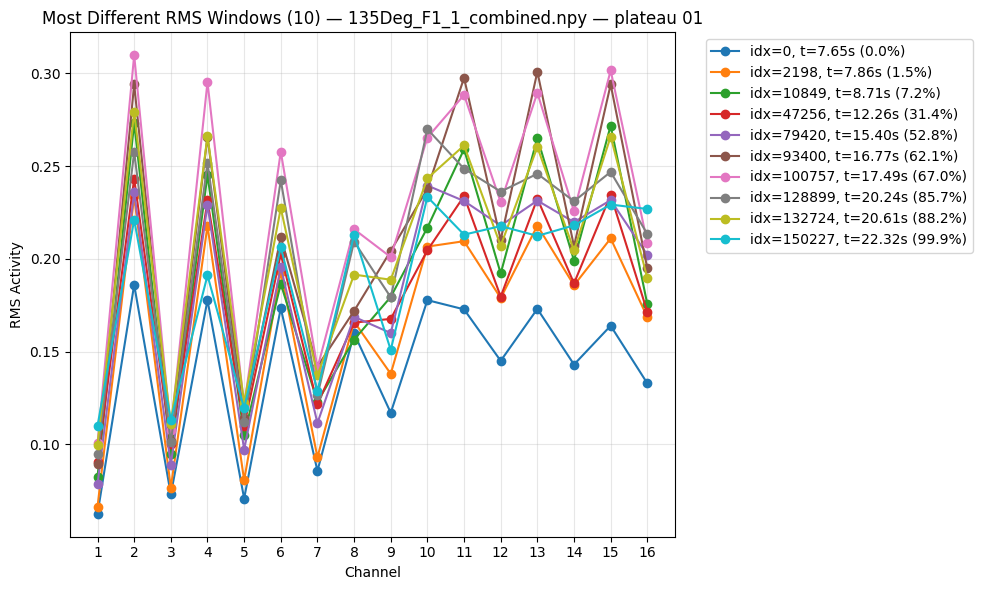


Most different windows:
  idx=   0, t=7.647s, at   0.0% of segment
  idx=2198, t=7.862s, at   1.5% of segment
  idx=10849, t=8.707s, at   7.2% of segment
  idx=47256, t=12.262s, at  31.4% of segment
  idx=79420, t=15.403s, at  52.8% of segment
  idx=93400, t=16.768s, at  62.1% of segment
  idx=100757, t=17.487s, at  67.0% of segment
  idx=128899, t=20.235s, at  85.7% of segment
  idx=132724, t=20.609s, at  88.2% of segment
  idx=150227, t=22.318s, at  99.9% of segment


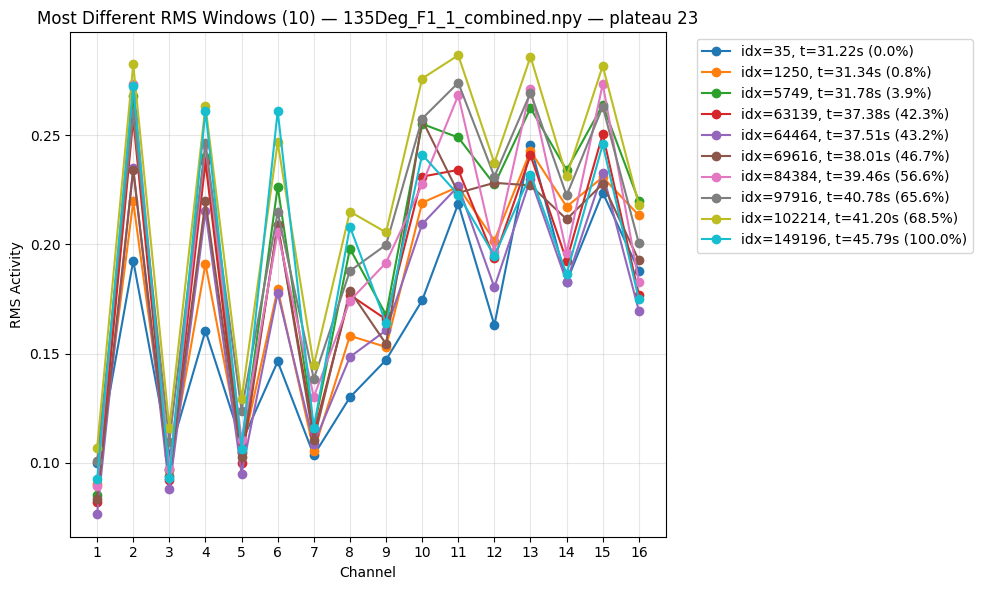


Most different windows:
  idx=  35, t=31.220s, at   0.0% of segment
  idx=1250, t=31.338s, at   0.8% of segment
  idx=5749, t=31.778s, at   3.9% of segment
  idx=63139, t=37.382s, at  42.3% of segment
  idx=64464, t=37.512s, at  43.2% of segment
  idx=69616, t=38.015s, at  46.7% of segment
  idx=84384, t=39.457s, at  56.6% of segment
  idx=97916, t=40.779s, at  65.6% of segment
  idx=102214, t=41.198s, at  68.5% of segment
  idx=149196, t=45.786s, at 100.0% of segment


In [48]:
plot_10_most_different_windows(FILE_135, plateau="01", k=10)
plot_10_most_different_windows(FILE_135, plateau="23", k=10)


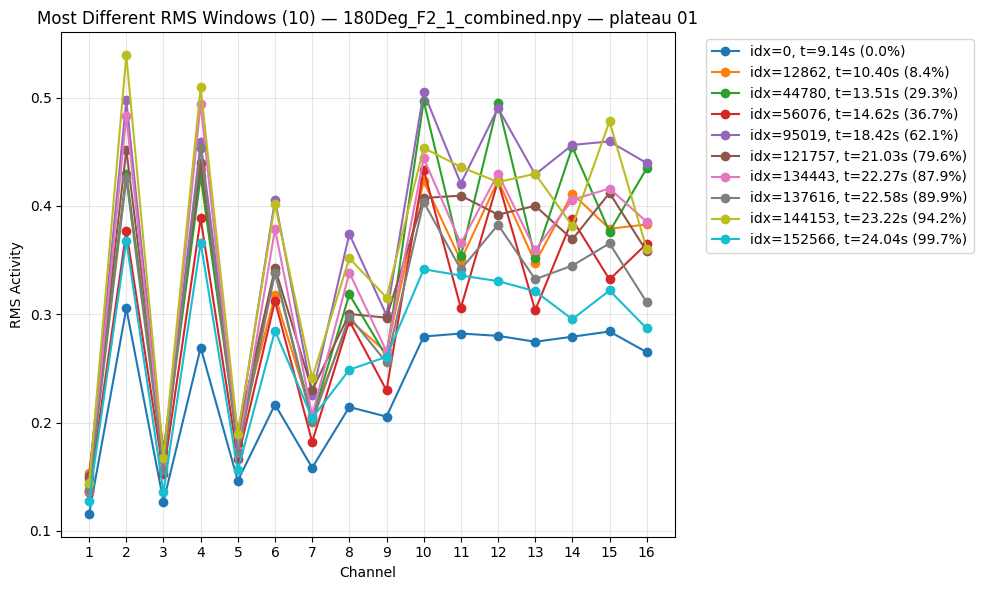


Most different windows:
  idx=   0, t=9.142s, at   0.0% of segment
  idx=12862, t=10.398s, at   8.4% of segment
  idx=44780, t=13.515s, at  29.3% of segment
  idx=56076, t=14.618s, at  36.7% of segment
  idx=95019, t=18.421s, at  62.1% of segment
  idx=121757, t=21.032s, at  79.6% of segment
  idx=134443, t=22.271s, at  87.9% of segment
  idx=137616, t=22.581s, at  89.9% of segment
  idx=144153, t=23.219s, at  94.2% of segment
  idx=152566, t=24.041s, at  99.7% of segment


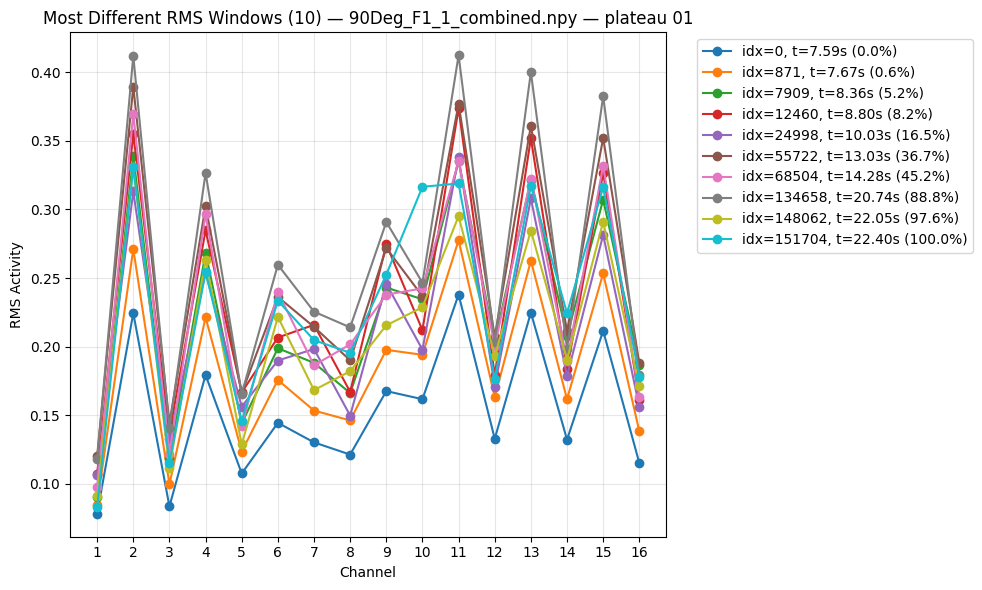


Most different windows:
  idx=   0, t=7.586s, at   0.0% of segment
  idx= 871, t=7.671s, at   0.6% of segment
  idx=7909, t=8.358s, at   5.2% of segment
  idx=12460, t=8.803s, at   8.2% of segment
  idx=24998, t=10.027s, at  16.5% of segment
  idx=55722, t=13.028s, at  36.7% of segment
  idx=68504, t=14.276s, at  45.2% of segment
  idx=134658, t=20.736s, at  88.8% of segment
  idx=148062, t=22.045s, at  97.6% of segment
  idx=151704, t=22.401s, at 100.0% of segment


In [49]:
plot_10_most_different_windows(FILE_180, plateau="01", k=10)
plot_10_most_different_windows(FILE_90, plateau="01", k=10)
